In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from IPython.display import display
import time
from scipy import stats
import hashlib

In [49]:
def get_data(filename):
    start = time.time()
    df1 = pd.read_csv(filename, sep='\t')
    df1 = df1.set_axis(["ATime", "Channel", "Signal", "Source", "Dest", "Seq", "SSID", "BSSID"], axis=1)

    df1["RTime"] = 0
    df1["Tag"] = "X"
    
    

    df1 = df1.drop(["SSID", "BSSID"], axis=1)
    freq_map = {2412: 1, 2437: 6, 2462: 11}
    df1 = df1.replace({"Channel": freq_map})
    
    df1 = df1[0:500000]

    for i in range(1, len(df1)):
        df1.loc[i, "Tag"] = str(df1.loc[i - 1, "Channel"]) + "->" + str(df1.loc[i, "Channel"])
        df1.loc[i, "CType"] = "Same" if str(df1.loc[i - 1, "Channel"])  == str(df1.loc[i, "Channel"]) else "Different"
        df1.loc[i, "RTime"] = df1.loc[i, "ATime"] - df1.loc[i - 1, "ATime"]

    df1 = df1.iloc[1:, :]

    df1 = df1.astype({"ATime": np.float32, "RTime": np.float32, "Signal": np.float32})

    end = time.time()
    print("Total Time: ", end - start)
    
    return df1
    

In [50]:
# get the data
df1 = get_data("../data/text/sample21.txt")
df2 = get_data("../data/text/sample22.txt")

Total Time:  102.5811243057251
Total Time:  106.93553829193115


First, we need to make sure we keep only the packets that we are interested in. We'll do this by looking for the MAC address that occurs the most frequently nearby the network cards.

In [51]:
print("Phone 1")
print("#" * 20)
display(df1[df1.Signal > -45].groupby("Source").size().sort_values(ascending=False))
print("#" * 20)
print("Phone 2")
print("#" * 20)
display(df2[df2.Signal > -45].groupby("Source").size().sort_values(ascending=False))

Phone 1
####################


Source
e8:50:8b:43:b1:20    9267
d1:a1:16:87:62:41      11
1a:d0:b9:35:30:d1      10
ec:50:8b:43:b1:20       2
74:a8:c5:a1:58:90       2
                     ... 
7e:20:bd:43:b1:20       1
7f:87:d4:a6:59:79       1
84:50:b2:e7:bd:fd       1
8a:c2:3a:09:d8:4e       1
fc:1c:89:43:b1:20       1
Length: 154, dtype: int64

####################
Phone 2
####################


Source
a8:86:60:da:7d:7b    84457
fc:01:7c:88:dc:af       16
a9:86:60:da:7d:7b       10
ec:84:60:da:7d:7b        5
a8:86:40:c8:7d:7b        4
                     ...  
64:ca:78:4d:e4:bf        1
64:c8:f7:40:79:b3        1
64:c8:ee:66:78:7b        1
64:c8:ab:65:7e:7e        1
88:d4:d5:70:78:7b        1
Length: 422, dtype: int64

In [71]:
df1 = df1[df1.Source == "e8:50:8b:43:b1:20"].iloc[0:100000]
df2 = df2[df2.Source == "a8:86:60:da:7d:7b"].iloc[0:100000]

df1["Phone"] = 1
df2["Phone"] = 2

df1["Time"] = df1["ATime"] - df1["ATime"].iloc[0]
df2["Time"] = df2["ATime"] - df2["ATime"].iloc[0]

df = pd.concat([df1, df2])
display(df)

,ATime,Channel,Signal,Source,Dest,Seq,RTime,Tag,CType,Phone,Time
334,1.667419e+09,1,-57.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff,1176.0,0.090282,6->1,Different,1,0.0
336,1.667419e+09,1,-57.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff,1177.0,0.000486,6->1,Different,1,0.0
337,1.667419e+09,1,-56.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff,1178.0,0.002232,1->1,Same,1,0.0
339,1.667419e+09,1,-55.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff,1179.0,0.015008,1->1,Same,1,0.0
340,1.667419e+09,1,-56.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff,1180.0,0.002451,1->1,Same,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
434491,1.668038e+09,1,-40.0,a8:86:60:da:7d:7b,ff:ff:ff:ff:ff:ff,266.0,0.082390,1->1,Same,2,96896.0
434492,1.668038e+09,1,-41.0,a8:86:60:da:7d:7b,ff:ff:ff:ff:ff:ff,267.0,0.002007,1->1,Same,2,96896.0
434495,1.668038e+09,6,-44.0,a8:86:60:da:7d:7b,ff:ff:ff:ff:ff:ff,271.0,0.029150,1->6,Different,2,96896.0
434496,1.668038e+09,6,-39.0,a8:86:60:da:7d:7b,ff:ff:ff:ff:ff:ff,272.0,0.062458,6->6,Same,2,96896.0


Let's see what the summary statistics for each phone looks like:

In [72]:
df[["Phone", "Tag", "RTime"]].groupby(["Tag", "Phone"]).describe()

RTime                                                    \
                count      mean       std       min       25%       50%   
Tag    Phone                                                              
1->1   1       5696.0  0.027975  0.139767  0.001247  0.001430  0.002074   
       2      16846.0  0.064797  0.256987  0.001788  0.002000  0.002427   
1->11  1        431.0  0.043828  0.100130  0.000015  0.000019  0.015570   
       2      12820.0  0.018095  0.037098  0.000008  0.000019  0.000020   
1->6   1       7480.0  0.002709  0.018125  0.000007  0.000018  0.000018   
       2       5004.0  0.063900  0.064622  0.000012  0.000020  0.058670   
11->1  1        698.0  0.336251  0.980155  0.000018  0.009513  0.030391   
       2      11704.0  0.213074  0.601931  0.000010  0.002006  0.053215   
11->11 1       7232.0  0.021771  0.115812  0.000155  0.001424  0.001873   
       2       9984.0  0.026079  0.032228  0.001786  0.001954  0.002219   
11->6  1        107.0  0.034032  0.042092  0.000019  0.008694  0.019194   
       2       7987.0  0.039002  0.034047  0.000016  0.001974  0.061872   
6->1   1       7484.0  0.051873  0.390681  0.000016  0.001402  0.001775   
       2       5871.0  0.306623  0.718168  0.000018  0.043009  0.064468   
6->11  1        571.0  0.084066  0.148745  0.000014  0.015880  0.049057   
       2       9134.0  0.030814  0.056281  0.000009  0.000019  0.000019   
6->6   1       1843.0  0.012152  0.019181  0.001255  0.001403  0.001758   
       2      20650.0  0.030228  0.032603  0.001791  0.001976  0.002598   

                                   
                   75%        max  
Tag    Phone                       
1->1   1      0.037328   5.266845  
       2      0.081053   8.155622  
1->11  1      0.061704   1.596551  
       2      0.002000   0.211877  
1->6   1      0.000019   0.245397  
       2      0.126799   0.315552  
11->1  1      0.139374  14.005203  
       2      0.064304   8.177402  
11->11 1      0.037223   2.069459  
       2      0.062329   0.199254  
11->6  1      0.036716   0.199900  
       2      0.062452   0.752091  
6->1   1      0.036226  11.535233  
       2      0.191084  12.143442  
6->11  1      0.121807   1.901559  
       2      0.036198   0.275632  
6->6   1      0.031719   0.183864  
       2      0.062372   0.212056

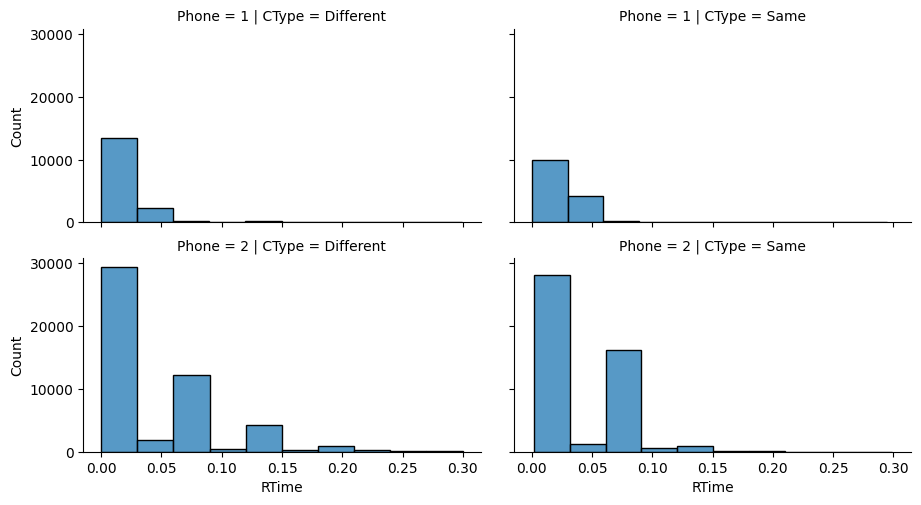

In [73]:
short = df.loc[df["RTime"] < 0.3, ["RTime", "CType", "Phone"]]
g = sns.FacetGrid(short, col="CType", sharey=True, sharex=True, row="Phone")
g.map(sns.histplot, "RTime", bins=10)
g.figure.set_size_inches(10, 5)
plt.show()

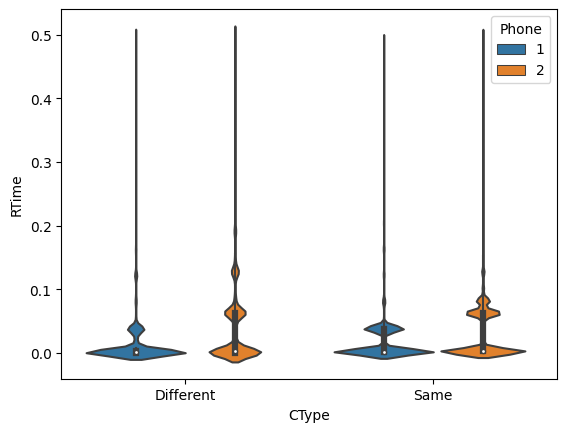

In [74]:
ds = df[df.RTime < 0.5].sort_values(by="Time")
sns.violinplot(ds, x="CType", y="RTime", hue="Phone")
plt.show()

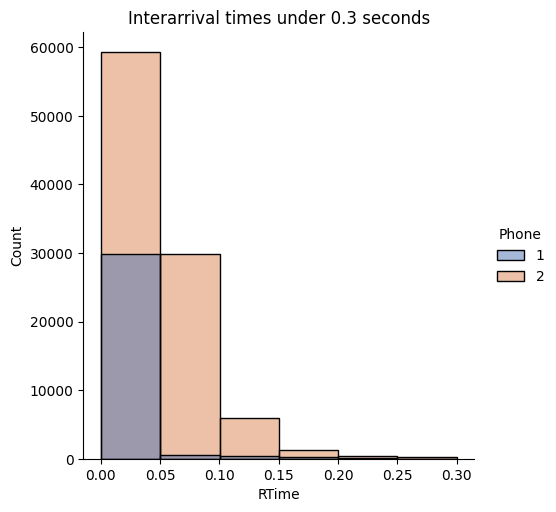

In [75]:
sns.displot(df[df.RTime < 0.3], x="RTime", hue="Phone", common_bins=True, bins=10, palette="deep", binwidth=0.05).set(title="Interarrival times under 0.3 seconds")
plt.show()

Let's take a look at the CDFs:

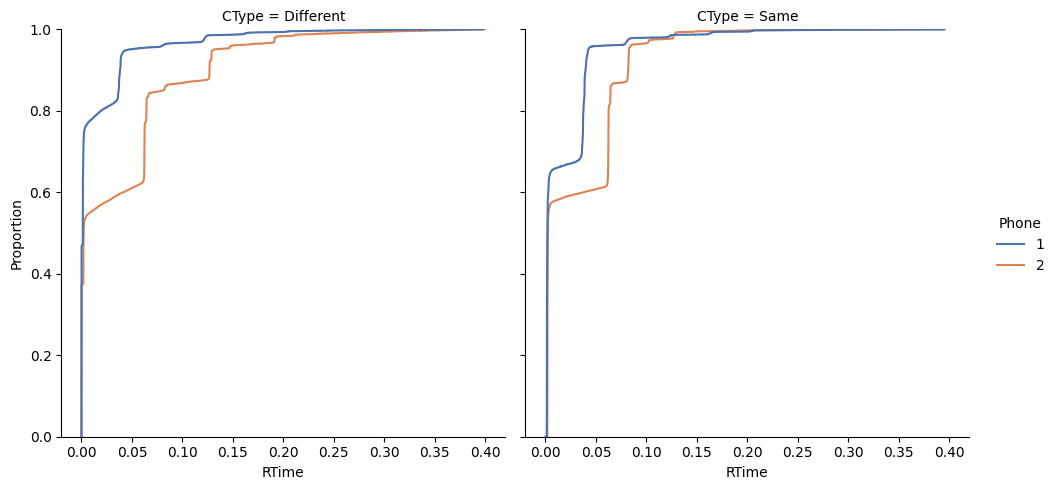

In [76]:
sns.displot(df[df.RTime < 0.4], x="RTime", col="CType", hue="Phone", kind="ecdf", palette="deep")
plt.show()

Let's try the KS test on each distribution (same channel probe or different channel probe):

In [77]:
for dist in ["Same", "Different"]:
        print(f"KS test for probes on {dist} channel:")
        print("#" * 20)
        ls = df[(df.Phone == 1) & (df.CType == dist)]["RTime"]
        rs = df[(df.Phone == 2) & (df.CType == dist)]["RTime"]
        x = stats.kstest(ls, rs)
        print(x)
        print("\n\n")

KS test for probes on Same channel:
####################
KstestResult(statistic=0.4704732690487297, pvalue=0.0)



KS test for probes on Different channel:
####################
KstestResult(statistic=0.3592697902296892, pvalue=0.0)





Since the P values are approximately 0, it appears that we should be able to classify a pair of packets based on the interarrival time. Since the interarrival time for two packets on the same channel approaches 0, we will end up using the interarrival time between two packets that are on different chanels.

In [78]:
df[df.CType == "Different"].loc[:, ["Phone", "RTime"]].groupby("Phone").describe()

RTime                                                              \
         count      mean       std       min       25%       50%       75%   
Phone                                                                        
1      16771.0  0.042556  0.337044  0.000007  0.000018  0.001374  0.003942   
2      52520.0  0.103555  0.388090  0.000008  0.000020  0.002555  0.064226   

                  
             max  
Phone             
1      14.005203  
2      12.143442

In [79]:
mean1 = df[df.CType == "Different"].loc[:, "RTime"].mean()
std1 = df[df.CType == "Different"].loc[:, "RTime"].std()

print(f"Variance to Mean ratio for phone 1: {std1**2/mean1}")

mean2 = df[df.CType == "Same"].loc[:, "RTime"].mean()
std2 = df[df.CType == "Same"].loc[:, "RTime"].std()

print(f"Variance to Mean ratio for phone 1: {std2**2/mean2}")

Variance to Mean ratio for phone 1: 1.603048169078197
Variance to Mean ratio for phone 1: 0.59264554957024


In [80]:
def to_local(string):
    try:
        x = bytearray(string, encoding="ascii")[1]
    except:
        return True
    
    y = (x >> 1) & 1
    return y == 1
    
df["Random"] = df["Source"].str[0:2].map(to_local)

In [88]:
def hash_string(string):
    x = string.encode("ascii")
    y = hashlib.md5(x)
    return y.hexdigest()
    
# df["Source"] = df["Source"].map(hash_string)

In [93]:
df[df.Phone == 1].sort_values(by="ATime").loc[:, ["Time", "Seq"]].head(100)

,Time,Seq
334,0.0,1176.0
368,0.0,1208.0
369,0.0,1209.0
370,0.0,1209.0
371,0.0,1210.0
...,...,...
2603,128.0,1340.0
2602,128.0,1340.0
2601,128.0,1339.0
2606,128.0,1342.0


[]

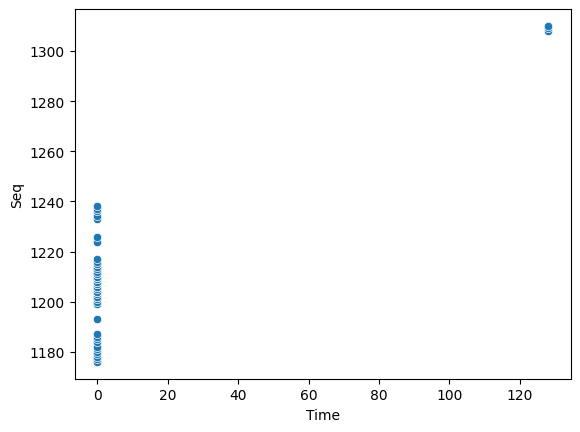

In [105]:
sns.scatterplot(df[df.Phone == 1].iloc[0:50], x="Time", y="Seq")
plt.plot()

In [ ]:
from sklearn import Kmeans